# Missteering measurement

Sooo it looks that the emittance is decreasing after injection for whatever reason.
Quick measurements at C171 seems to show that the blowup follows the analytical expectation.
Let's see then ! 

In [1]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/PS-injection-steering/Data analysis/2018.05.17
Your IP is 172.17.0.6
2018-07-16 14:01:22
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [2]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [3]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17'

matlabVars = ['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 65
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'logical_PI_KFA45.K.value', # Kicker k parameter value (mrad)
                'PI_KFA45.AQN1.value',
                'PI_KFA45.CCV.value', 
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BCT_ST.Samples.value.samples']



In [4]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 170 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/data/2018.05.17.12.31.14.896.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/data/2018.05.17.14.36.17.287.mat


In [5]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

# Data cleanup

In [6]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:59:28.300000'].name) # non-phys emittance

No duplicates found
---
BPM data ok
---


# Load the reference kick

In [7]:
refPath = folderPath+'/refKicker.mat'
scipy.io.whosmat(refPath)
rk = scipy.io.loadmat(refPath)['k'][0][0]
print(rk)

0.003643


# Import the optics model

In [8]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/PS-injection-steering/MADx/PS_twiss_files/ps_6.21_6.185.twiss')

Problem parsing: @ ORBIT_-CT        %le                  -0

Going to be parsed as string
Problem persits, let's ignore it!


# Booster emittance

In [9]:
emix_norm_PSB = 2.484
emiy_norm_PSB = 2.076

emix_geom_PSB = emix_norm_PSB/(betar*gammar)
emiy_geom_PSB = emiy_norm_PSB/(betar*gammar)

NameError: name 'betar' is not defined

# Find the shift value

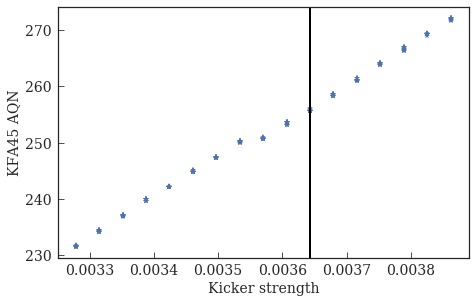

In [10]:
shiftVal=1
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['PI_KFA45.AQN1.value'],'*')
plt.xlabel('Kicker strength')
plt.ylabel('KFA45 AQN')
plt.axvline(x=rk, ymin=0, ymax = 8, linewidth=2, color='k')

# Match the tomogram data

In [11]:
# directly copied from one of Guido's analyses
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt(fileName[0:-4] + '/d001.data')
    image=np.loadtxt(fileName[0:-4] + '/image001.data')
    with open(fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2]),
            'cycleStamp':np.int(tomofileheader[1]),                    # cyclestamp in unix time
            'pickupSensitivity':np.double(tomofileheader[97])          # pickup sensitivity
    }

    with open(fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [12]:
# new tomogram analysis
files_tomo=sorted(glob.glob(folderPath+'/tomo_data/*.dat'))

tomo_data = pnd.DataFrame()

for f in range(len(files_tomo)):
    try:
        tomo_d = extractProfile(files_tomo[f])
        tomo_d['Filename'] = files_tomo[f]
        if tomo_d is np.nan:
            pass
        else:
            tomo_data=tomo_data.append(tomo_d,ignore_index=True)
    except IOError:
        print '\nIOError\n'

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_001.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_002.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_003.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_004.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_005.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_006.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_052.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_053.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_054.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_055.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_056.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_057.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_103.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_104.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_105.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_106.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_107.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_108.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_154.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_155.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_156.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_157.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_158.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_159.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_205.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_206.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_207.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_208.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_209.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_210.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_256.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.17/tomo_data/autosave_257.dat


In [13]:
timeTolerance = 22

# ---------- Vars initialisation
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['tomoFilename']=np.str
myDataFrame['deltaP_P_rms']=np.nan
myDataFrame['peakLineDensity']=np.nan
myDataFrame['beta']=np.nan
myDataFrame['gamma']=np.nan
myDataFrame['deltaP_P']=[np.empty(0,dtype=float)]*len(myDataFrame)
myDataFrame['momentumProfile']=[np.empty(0,dtype=float)]*len(myDataFrame)


succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomo_data)):
    tomo_local_cs = tomo_data['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    tomo_fname = tomo_data['Filename'].iloc[k]
    tomo_dpprms = tomo_data['deltaP_P_RMS'].iloc[k]
#     tomo_pkldens = tomo_data['peakLineDensity'].iloc[k]
    betar = tomo_data['beta'].iloc[k]
    gammar = tomo_data['gamma'].iloc[k]
    dpp_profil = tomo_data['deltaP_P'].iloc[k]
    p_profil = tomo_data['myProfile'].iloc[k]    


    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoFilename'].iloc[x] = tomo_fname
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['deltaP_P_rms'].iloc[x]= tomo_dpprms
#             myDataFrame['peakLineDensity'].iloc[x]= tomo_pkldens
            myDataFrame['beta'].iloc[x]= betar
            myDataFrame['gamma'].iloc[x]= gammar
            myDataFrame['deltaP_P'].iloc[x]= dpp_profil
            myDataFrame['momentumProfile'].iloc[x]= p_profil


            succ_count += 1 #dummy counter
            
print str(succ_count) +"/"+ str(len(tomo_data)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


169/257 are within the timeTolerance
length of dataframe is: 170


In [14]:
# discard the elements without tomogram
discFlag = np.isnan(myDataFrame['tomoDelta'].values)
myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

# Save the imported data

In [15]:
myDataFrame.to_pickle('imported_data_2018.05.17.pkl')

In [16]:
# myDataFrame=pnd.read_pickle('imported_data_2018.05.17.pkl')

# Intensity

In [17]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][100]/np.max(x) )

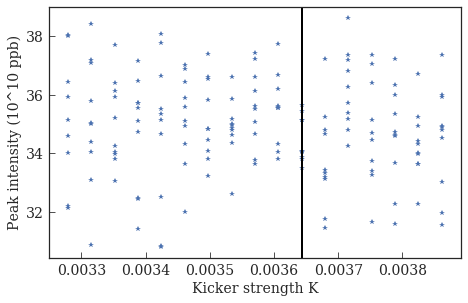

In [18]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')
plt.axvline(x=rk, ymin=0, ymax = 8, linewidth=2, color='k')

Text(0,0.5,u'Losses')

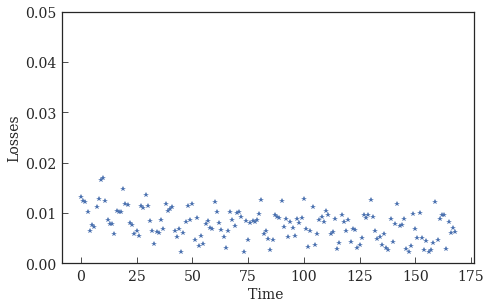

In [19]:
plt.plot(np.linspace(0,len(myDataFrame)-1,len(myDataFrame)),myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,0.05))
plt.xlabel('Time ')
plt.ylabel('Losses')

Text(0.5,1,u'10 shots intensity')

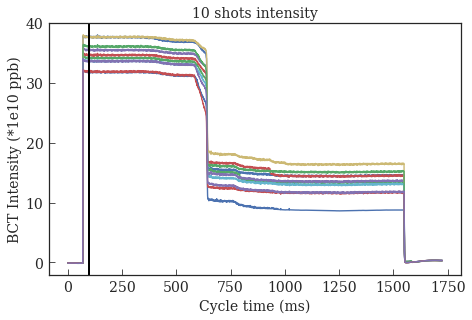

In [20]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=100, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

In [21]:
# drop the first 40 measurements, lossy ...

myDataFrame = myDataFrame.drop(myDataFrame.iloc[0:40].index)

# Calculate wire scanner emittance
## X plane
### Traditional method

In [22]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [23]:
# Emittance calculation
myDataFrame['WS_emittance_x'] = np.nan
myDataFrame['WS_geom_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=myDataFrame['deltaP_P_rms'].values[n])
    myDataFrame['WS_geom_emittance_x'].iloc[n] = myDataFrame['WS_emittance_x'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

### Dispersive profile deconvolution

In [24]:
# BWS65
betax = 21.77988929
Dx = 3.24577470

betax = 20.11
Dx = 3.2

def deconv_caller(row):
    return myToolbox.computeTransverseEmittance(row['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'],
                              row['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'],
                              row['momentumProfile'],
                              row['deltaP_P'],
                              row['beta']*row['gamma'],
                              betaOptical_m=betax,Dispersion_m=Dx)

myDataFrame['Deconvolution_result'] = myDataFrame.apply(deconv_caller,axis=1)



for k in myDataFrame.index:  
    myDataFrame.loc[k,'Emittance_x_deconv'] = myDataFrame.loc[k,('Deconvolution_result')]['emittance_um']


## Y plane

In [25]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

In [26]:
# Emittance calculation
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance('85V',x))

myDataFrame['WS_geom_emittance_y'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_geom_emittance_y'].iloc[n] = myDataFrame['WS_emittance_y'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

## Calculate average emittance per measurement point

In [27]:
# find indexes of the shots at the same kick
ks = []
ks_idx = []
for k in range(len(myDataFrame)):
    if k == 0 :
        prevk = myDataFrame['logical_PI_KFA45.K.value'].iloc[k]
        ks.append(prevk)
        ks_idx.append(k)
        continue
#     print(k)
    
    thisk = myDataFrame['logical_PI_KFA45.K.value'].iloc[k]
    if (prevk-thisk) != 0:
#         print(thisk)
        ks.append(thisk)
        ks_idx.append(k)
    prevk = thisk

In [28]:
k_values = np.array((myDataFrame['logical_PI_KFA45.K.value'].iloc[ks_idx]))

emix_mean = np.empty(len(ks_idx),dtype=float)
emiy_mean = np.empty(len(ks_idx),dtype=float)
emix_std = np.empty(len(ks_idx),dtype=float)
emiy_std = np.empty(len(ks_idx),dtype=float)


for k in range(len(ks_idx)):
    if k==len(ks_idx)-1:
        emix_mean[k] = np.mean(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emiy_mean[k] = np.mean(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emix_std[k] = np.std(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emiy_std[k] = np.std(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:]) # the last tranche to close the array
    else:
        emix_mean[k] = np.mean(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emiy_mean[k] = np.mean(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emix_std[k] = np.std(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emiy_std[k] = np.std(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:ks_idx[k+1]])



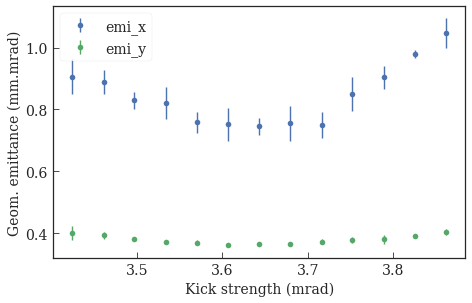

In [29]:
fig, ax = plt.subplots(1)

ax.errorbar(1e3*k_values, emix_mean, yerr=emix_std, fmt='o',label='emi_x')
ax.errorbar(1e3*k_values, emiy_mean, yerr=emiy_std, fmt='o',label='emi_y')

plt.xlabel('Kick strength (mrad)')
plt.ylabel('Geom. emittance (mm.mrad)')
# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,4,6.2))



plt.legend(frameon=True)

fig.savefig('BCMS_under_coupling_emi_xy.eps', format='eps')

## Emittance plot

In [30]:
shiftVal =1

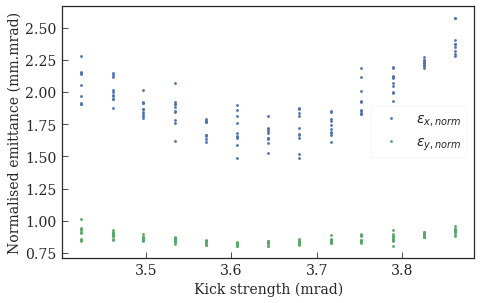

In [32]:
fig, ax = plt.subplots(1)

ax.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_x'],'.',label='$\epsilon_{x, norm}$')
plt.xlabel('Kick strength (mrad)')
plt.ylabel('Normalised emittance (mm.mrad)')
# plt.axvline(x=rk, ymin=0, ymax = 8, linewidth=2, color='k')
# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,4,6.2))


ax.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_y'],'.',label='$\epsilon_{y, norm}$')

plt.legend(frameon=True)

fig.savefig('BCMS_under_coupling_emi_xy.eps', format='eps')

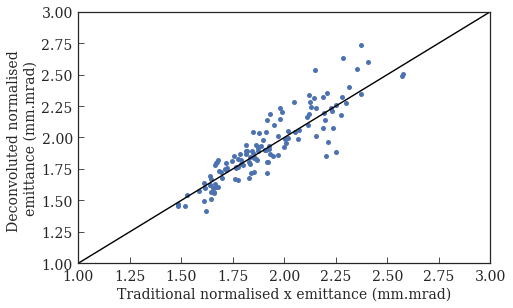

In [33]:
fig2, ax2 = plt.subplots(1)
ax2.plot(myDataFrame['WS_emittance_x'],myDataFrame['Emittance_x_deconv'],'.',markersize=10)
plt.xlabel('Traditional normalised x emittance (mm.mrad)')
plt.ylabel('Deconvoluted normalised \nemittance (mm.mrad)')

ax2.plot([.5,10.],[.5,10.],'-k')
x1,x2,y1,y2 = plt.axis()
plt.axis((1.,3.,1.,3.))

fig2.savefig('BCMS_under_coupling_Wemi_vs_deconv.eps', format='eps')

In [34]:
# get KFA45 optics parameters
optics_names = optics.NAME

for k in range(len(optics_names)):
    if optics_names[k].find('PI.KFA45') != -1:
        print optics_names[k]
        kicker_name = optics_names[k]
        kicker_idx = k
        kicker_betax = optics.BETA11[k]
        kicker_alphax = optics.ALFA11[k]

PI.KFA45


Model function: a(x - b)^2 + c
Fit params: a=5.58785940852 b= 0.00362617978778 c= 7.46143987123e-07
Expected a=11.31979295


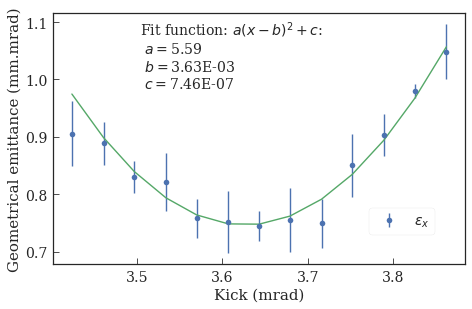

In [35]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = k_values       #rad
ydata = 1e-6*emix_mean # m

fig, ax = plt.subplots(1)
ax.errorbar(1e3*k_values, emix_mean, yerr=emix_std, fmt='o',label='$\epsilon_x$')

#fit and plot fit
p, cov = curve_fit(f_to_fit,xdata,ydata,sigma=emiy_std)#, maxfev=int(1e5))
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])
ax.plot(1e3*xdata, 1e6*f_to_fit(xdata,*p))




plt.xlabel('Kick (mrad)',fontsize=15)
plt.ylabel('Geometrical emittance (mm.mrad)',fontsize=15)

ax.text(0.21, 0.98, 'Fit function: $a(x-b)^2+c$:\n $a=$%.2f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0.7,2.3))


print 'Expected a='+str(kicker_betax/2)


plt.legend(bbox_to_anchor=(0.75,.25),loc=2,frameon=True)

# ax.errorbar(1e3*k_values, emiy_mean, yerr=emiy_std, fmt='o',label='emi_x')



# x1,x2,y1,y2 = plt.axis()
# plt.axis((3.45,4.15,.6,2.))

fig.savefig('emi_x_fitC171.eps', format='eps',dpi=100)

# BPMs

In [36]:
# BPMs
# BPMs
myDataFrame['BPMx'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[0:43,:])
myDataFrame['BPMy'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[-43:,:])

#legacy from now on
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
# #turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

In [138]:
# get the twiss at the BPMs position
optics_names = optics.NAME
BPM_name = []
BPM_idx = []
BPM_betax = []
BPM_alphax = []
BPM_betay = []
BPM_alphay = []

for k in range(len(optics_names)):
    if optics_names[k].find('PR.BPM') != -1:
#        print optics_names[k]
        BPM_name.append(optics_names[k])
        BPM_idx.append(k)
        BPM_betax.append(optics.BETA11[k])   
        BPM_alphax.append(optics.ALFA11[k])
        BPM_betay.append(optics.BETA22[k])   
        BPM_alphay.append(optics.ALFA22[k])

# for some reason the last bpm is the 00, place it back at the beginning
BPM_name = [BPM_name[-1]] + BPM_name[:-1]
BPM_idx = [BPM_idx[-1]] + BPM_idx[:-1]
BPM_betax = [BPM_betax[-1]] + BPM_betax[:-1]
BPM_alphax = [BPM_alphax[-1]] + BPM_alphax[:-1]
BPM_betay = [BPM_betay[-1]] + BPM_betay[:-1]
BPM_alphay = [BPM_alphay[-1]] + BPM_alphay[:-1]

# casting stuff
BPM_betax = np.array(BPM_betax)
BPM_alphax = np.array(BPM_alphax)
BPM_betay = np.array(BPM_betay)
BPM_alphay = np.array(BPM_alphay)

## Get the transfer matrix between the BPMs

So for example for BPM00 and BPM03

$$
\begin{pmatrix}
  x  \\
  x^\prime
 \end{pmatrix}_\text{BPM00}
=
\begin{pmatrix}
  a & b \\
  c & d
 \end{pmatrix}
\begin{pmatrix}
  x  \\
  x^\prime
 \end{pmatrix}_\text{BPM03}
$$

so the angle at the first BPM can be obtained just from the position at the two, if the optics model is known
$$
x^\prime_\text{BPM00} = c x_\text{BPM00} + \frac{d}{b} (x_\text{BPM03} - a x_\text{BPM00})
$$


In [38]:
# load transfer matrixes
X_TM = [] # --> X_TM[0] is the matrix between BPM03 and BPM00
Y_TM = []

for k in range(43):
    fname = 'sector'+str(k)+'.sec'
    imported_twiss = metaclass.twiss('/eos/user/e/esenes/PS-injection-steering/MADx/transfer_matrix_BPMs/6.21-6.185/'+fname)

    x_transfer_matrix = np.matrix([[imported_twiss.R11[-1], imported_twiss.R12[-1]],[imported_twiss.R21[-1], imported_twiss.R22[-1]]],dtype=float)
    y_transfer_matrix = np.matrix([[imported_twiss.R33[-1],imported_twiss.R34[-1]],[imported_twiss.R43[-1],imported_twiss.R44[-1]]],dtype=float)

    X_TM.append(x_transfer_matrix)
    Y_TM.append(y_transfer_matrix)

print('Done.')

Done.


In [39]:
def getAngle(transfer_matrix, thisBPM, nextBPM):
    a = transfer_matrix[0,0]
    b = transfer_matrix[0,1]
    c = transfer_matrix[1,0]
    d = transfer_matrix[1,1]
    return (c*thisBPM) + ((d/b)*(nextBPM - (a*thisBPM)))

## Get the angles

In [40]:
turnNumber = 5000
BPM_n = 43

nanMatrix = np.empty((int(BPM_n),int(turnNumber)),dtype=float); nanMatrix[:]=np.nan
myDataFrame['BPMx_angle'] = [nanMatrix]*len(myDataFrame)
myDataFrame['BPMy_angle'] = [nanMatrix]*len(myDataFrame)

for name in myDataFrame.index:
    # init
    nanMatrixX = np.empty((int(BPM_n),int(turnNumber)),dtype=float); nanMatrixX[:]=np.nan
    nanMatrixY = np.empty((int(BPM_n),int(turnNumber)),dtype=float); nanMatrixY[:]=np.nan

    for k in range(BPM_n-1):
        # X BPMs
        thisBPM = myDataFrame['BPMx'].loc[name][k,:]
        nextBPM = myDataFrame['BPMx'].loc[name][k+1,:]

        nanMatrixX[k, :] = getAngle(X_TM[k], thisBPM, nextBPM) 

        # Y BPMs
        thisBPM = myDataFrame['BPMy'].loc[name][k,:]
        nextBPM = myDataFrame['BPMy'].loc[name][k+1,:]

        nanMatrixY[k, :] = getAngle(Y_TM[k], thisBPM, nextBPM) 
    #last BPM
    k = BPM_n-1

    thisBPM = myDataFrame['BPMx'].loc[name][k,:]
    nextBPM = myDataFrame['BPMx'].loc[name][0,:]
    nanMatrixX[k, :] = getAngle(X_TM[k], thisBPM, nextBPM) 

    thisBPM = myDataFrame['BPMy'].loc[name][k,:]
    nextBPM = myDataFrame['BPMy'].loc[name][0,:]
    nanMatrixY[k, :] = getAngle(Y_TM[k], thisBPM, nextBPM) 

    #store data
    myDataFrame['BPMx_angle'].loc[name] = nanMatrixX
    myDataFrame['BPMy_angle'].loc[name] = nanMatrixY

    
    

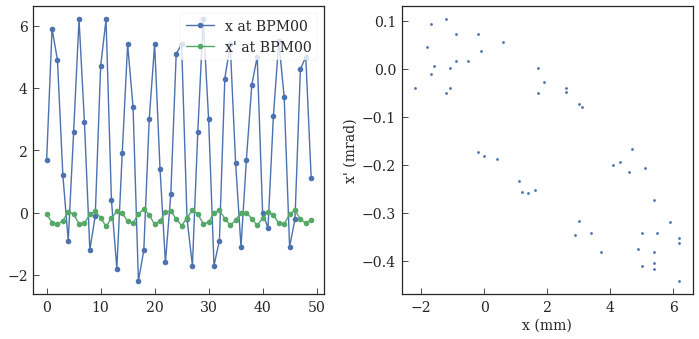

In [45]:
k=1
off = 0
m = 0
ydata1 = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m,:50]).values[k] #thisBPM
ydata2 = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m+1,:50]).values[k] #nextBPM

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(ydata1,'o-',label='x at BPM00')

angles = getAngle(Y_TM[m], ydata1, ydata2)

ax[0].plot(angles,'o-',label='x\' at BPM00')
ax[0].legend(frameon=True, loc=1)

ax[1].plot(ydata1, angles,'.')
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('x\' (mrad)')

fig.tight_layout()

# Calculate injection oscillation from the BPM

## 1. Look at one BPM and calculate the oscillation over the first 50 turns

In [46]:
# get the beta at the BPMs position
optics_names = optics.NAME
BPM_name = []
BPM_idx = []
BPM_betax = []
BPM_alphax = []

for k in range(len(optics_names)):
    if optics_names[k].find('PR.BPM') != -1:
#        print optics_names[k]
        BPM_name.append(optics_names[k])
        BPM_idx.append(k)
        BPM_betax.append(optics.BETA11[k])   
        BPM_alphax.append(optics.ALFA11[k])

# for some reason the last bpm is the 00, place it back at the beginning
BPM_name = [BPM_name[-1]] + BPM_name[:-1]
BPM_idx = [BPM_idx[-1]] + BPM_idx[:-1]
BPM_betax = [BPM_betax[-1]] + BPM_betax[:-1]
BPM_alphax = [BPM_alphax[-1]] + BPM_alphax[:-1]

In [88]:
# loop over all the BPM --> in vertical ! 
verticalMode = False

if verticalMode:
    off = 43
else:
    off = 0

chi2_thr = 1.   
    
# fit an harmonic function through the oscillations and extrapolate the amplitude. 
# possible tunes (non integer part) have been restricted to be between .20 and .25 --> 2pi/5 and pi/2

from scipy.optimize import curve_fit
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,30,30)
osc_amplitude = np.empty([len(myDataFrame),len(BPM_name)],dtype=float); osc_amplitude[:]=np.nan

# statistical check
chi2 = np.empty([len(myDataFrame),len(BPM_name)],dtype=float)

for m in range(len(BPM_name)):

    for k in range(len(myDataFrame)):
        ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m,0:30]).values[k]
        # starting values
        phase = 0.41*pi
        p0 = ([1.5*np.std(ydata), phase, 0.1*pi, np.mean(ydata)])
        # fit boundaries 
        bounds=([0.5*np.std(ydata), .8*pi/5, -pi, -np.inf],[3*np.std(ydata),pi/2.,pi,np.inf])

        try:
            p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)
            osc_amplitude[k,m] = np.abs(p[0])

            yfit = f_to_fit(xdata, *p)
            chi2[k,m] = np.sum((yfit - ydata)**2)/len(yfit)
            while chi2[k,m] > chi2_thr:
                print('chi2 = '+str(chi2[k,m])+' exceding the limit')

                phase += 0.03
                p0 = ([1.5*np.std(ydata), phase, -pi/2, np.mean(ydata)])
                p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)
                osc_amplitude[k,m] = np.abs(p[0])

                yfit = f_to_fit(xdata, *p)
                chi2[k,m] = np.sum((yfit - ydata)**2)/len(yfit)
                print('Refitting, new chi2 = '+str(chi2[k,m]))
                
                if phase > 0.45*pi:
                    print('END phase reached')
                    raise RuntimeError


        except RuntimeError:
            print 'fit do not converge on shot '+str(k)
            osc_amplitude[k,m] = np.nan
            chi2[k,m] = np.nan
        
    print BPM_name[m] + ' processed with success '+ str(np.count_nonzero(~np.isnan(osc_amplitude[:,m]))) +'/'+str(len(myDataFrame))+' shots'
            
print 'Done.'

chi2 = 1.08250048835 exceding the limit
Refitting, new chi2 = 0.315639559958
chi2 = 1.72858790813 exceding the limit
Refitting, new chi2 = 0.447915798441
chi2 = 1.49729464583 exceding the limit
Refitting, new chi2 = 0.589103142032
chi2 = 1.49861896949 exceding the limit
Refitting, new chi2 = 0.2963328793
chi2 = 1.99780632831 exceding the limit
Refitting, new chi2 = 0.615138099785
chi2 = 2.5024640374 exceding the limit
Refitting, new chi2 = 0.443042094832
chi2 = 2.84594366867 exceding the limit
Refitting, new chi2 = 0.454934950969
chi2 = 2.3279684597 exceding the limit
Refitting, new chi2 = 0.506222611753
chi2 = 2.66102130448 exceding the limit
Refitting, new chi2 = 0.659833134167
chi2 = 2.24814943607 exceding the limit
Refitting, new chi2 = 0.381343129002
chi2 = 2.09344740696 exceding the limit
Refitting, new chi2 = 0.655288973849
chi2 = 4.35591009221 exceding the limit
Refitting, new chi2 = 0.577634986264
chi2 = 3.31483690813 exceding the limit
Refitting, new chi2 = 0.567844384499
chi

chi2 = 1.02644093634 exceding the limit
Refitting, new chi2 = 1.02644093634
chi2 = 1.02644093634 exceding the limit
Refitting, new chi2 = 1.02644093634
chi2 = 1.02644093634 exceding the limit
Refitting, new chi2 = 1.02644093634
chi2 = 1.02644093634 exceding the limit
Refitting, new chi2 = 1.02644093634
chi2 = 1.02644093634 exceding the limit
Refitting, new chi2 = 1.02644093634
END phase reached
fit do not converge on shot 33
chi2 = 1.10735558939 exceding the limit
Refitting, new chi2 = 1.10735558946
chi2 = 1.10735558946 exceding the limit
Refitting, new chi2 = 1.1073555894
chi2 = 1.1073555894 exceding the limit
Refitting, new chi2 = 1.1073555894
chi2 = 1.1073555894 exceding the limit
Refitting, new chi2 = 1.10735558939
chi2 = 1.10735558939 exceding the limit
Refitting, new chi2 = 1.10735558939
END phase reached
fit do not converge on shot 71
chi2 = 1.58707411079 exceding the limit
Refitting, new chi2 = 1.58707411055
chi2 = 1.58707411055 exceding the limit
Refitting, new chi2 = 1.587074

fit do not converge on shot 84
chi2 = 1.91231665076 exceding the limit
Refitting, new chi2 = 0.559663244741
chi2 = 2.35453629327 exceding the limit
Refitting, new chi2 = 0.836918957402
chi2 = 1.59686996005 exceding the limit
Refitting, new chi2 = 0.756207338208
chi2 = 2.62456169844 exceding the limit
Refitting, new chi2 = 0.711994364933
chi2 = 4.67385432246 exceding the limit
Refitting, new chi2 = 0.83144439069
chi2 = 2.29288710822 exceding the limit
Refitting, new chi2 = 0.456923207966
chi2 = 4.39006360945 exceding the limit
Refitting, new chi2 = 0.514369219423
chi2 = 1.25660682929 exceding the limit
Refitting, new chi2 = 1.25660682926
chi2 = 1.25660682926 exceding the limit
Refitting, new chi2 = 1.25660682953
chi2 = 1.25660682953 exceding the limit
Refitting, new chi2 = 1.25660682933
chi2 = 1.25660682933 exceding the limit
Refitting, new chi2 = 1.25660682953
chi2 = 1.25660682953 exceding the limit
Refitting, new chi2 = 11.634951606
END phase reached
fit do not converge on shot 112
ch

chi2 = 1.22316057445 exceding the limit
Refitting, new chi2 = 1.22316057401
chi2 = 1.22316057401 exceding the limit
Refitting, new chi2 = 1.22316057389
chi2 = 1.22316057389 exceding the limit
Refitting, new chi2 = 1.22316057453
chi2 = 1.22316057453 exceding the limit
Refitting, new chi2 = 1.22316057384
chi2 = 1.22316057384 exceding the limit
Refitting, new chi2 = 1.22316057449
END phase reached
fit do not converge on shot 109
chi2 = 1.0792980757 exceding the limit
Refitting, new chi2 = 1.07929807569
chi2 = 1.07929807569 exceding the limit
Refitting, new chi2 = 1.07929807569
chi2 = 1.07929807569 exceding the limit
Refitting, new chi2 = 1.07929807569
chi2 = 1.07929807569 exceding the limit
Refitting, new chi2 = 1.0792980757
chi2 = 1.0792980757 exceding the limit
Refitting, new chi2 = 1.07929807573
END phase reached
fit do not converge on shot 123
chi2 = 1.14829955864 exceding the limit
Refitting, new chi2 = 1.14829955867
chi2 = 1.14829955867 exceding the limit
Refitting, new chi2 = 1.148

Refitting, new chi2 = 1.1297644238
END phase reached
fit do not converge on shot 77
chi2 = 1.01548985023 exceding the limit
Refitting, new chi2 = 1.01548985105
chi2 = 1.01548985105 exceding the limit
Refitting, new chi2 = 1.01548984977
chi2 = 1.01548984977 exceding the limit
Refitting, new chi2 = 1.01548985069
chi2 = 1.01548985069 exceding the limit
Refitting, new chi2 = 1.01548985008
chi2 = 1.01548985008 exceding the limit
Refitting, new chi2 = 1.01548984967
END phase reached
fit do not converge on shot 82
chi2 = 1.10982079473 exceding the limit
Refitting, new chi2 = 1.10982079475
chi2 = 1.10982079475 exceding the limit
Refitting, new chi2 = 1.10982079471
chi2 = 1.10982079471 exceding the limit
Refitting, new chi2 = 1.10982079463
chi2 = 1.10982079463 exceding the limit
Refitting, new chi2 = 1.10982079493
chi2 = 1.10982079493 exceding the limit
Refitting, new chi2 = 1.10982079486
END phase reached
fit do not converge on shot 91
chi2 = 1.07152766278 exceding the limit
Refitting, new chi

Refitting, new chi2 = 1.37813656236
END phase reached
fit do not converge on shot 34
chi2 = 1.14582024906 exceding the limit
Refitting, new chi2 = 1.14582024905
chi2 = 1.14582024905 exceding the limit
Refitting, new chi2 = 1.14582024906
chi2 = 1.14582024906 exceding the limit
Refitting, new chi2 = 1.14582024906
chi2 = 1.14582024906 exceding the limit
Refitting, new chi2 = 1.14582024905
chi2 = 1.14582024905 exceding the limit
Refitting, new chi2 = 1.14582024906
END phase reached
fit do not converge on shot 38
chi2 = 1.29658306496 exceding the limit
Refitting, new chi2 = 1.29658306586
chi2 = 1.29658306586 exceding the limit
Refitting, new chi2 = 1.29658306486
chi2 = 1.29658306486 exceding the limit
Refitting, new chi2 = 1.29658306492
chi2 = 1.29658306492 exceding the limit
Refitting, new chi2 = 1.29658306467
chi2 = 1.29658306467 exceding the limit
Refitting, new chi2 = 1.29658306463
END phase reached
fit do not converge on shot 41
chi2 = 1.11095408638 exceding the limit
Refitting, new ch

chi2 = 1.10846303089 exceding the limit
Refitting, new chi2 = 1.10846303089
chi2 = 1.10846303089 exceding the limit
Refitting, new chi2 = 1.10846303089
chi2 = 1.10846303089 exceding the limit
Refitting, new chi2 = 1.10846303091
chi2 = 1.10846303091 exceding the limit
Refitting, new chi2 = 1.1084630309
chi2 = 1.1084630309 exceding the limit
Refitting, new chi2 = 7.11374427394
END phase reached
fit do not converge on shot 113
chi2 = 1.32931594536 exceding the limit
Refitting, new chi2 = 1.32931594523
chi2 = 1.32931594523 exceding the limit
Refitting, new chi2 = 1.32931594522
chi2 = 1.32931594522 exceding the limit
Refitting, new chi2 = 1.3293159452
chi2 = 1.3293159452 exceding the limit
Refitting, new chi2 = 1.32931594517
chi2 = 1.32931594517 exceding the limit
Refitting, new chi2 = 7.63888397115
END phase reached
fit do not converge on shot 115
chi2 = 1.24309292054 exceding the limit
Refitting, new chi2 = 1.24309292052
chi2 = 1.24309292052 exceding the limit
Refitting, new chi2 = 1.2430

Refitting, new chi2 = 109.932921215
chi2 = 109.932921215 exceding the limit
Refitting, new chi2 = 109.932921348
END phase reached
fit do not converge on shot 3
chi2 = 68.5634178802 exceding the limit
Refitting, new chi2 = 87.3128510127
chi2 = 87.3128510127 exceding the limit
Refitting, new chi2 = 87.3128510127
chi2 = 87.3128510127 exceding the limit
Refitting, new chi2 = 111.295758102
chi2 = 111.295758102 exceding the limit
Refitting, new chi2 = 111.295757841
chi2 = 111.295757841 exceding the limit
Refitting, new chi2 = 111.295757998
END phase reached
fit do not converge on shot 4
chi2 = 91.3522597444 exceding the limit
Refitting, new chi2 = 86.4072858391
chi2 = 86.4072858391 exceding the limit
Refitting, new chi2 = 86.4072858391
chi2 = 86.4072858391 exceding the limit
Refitting, new chi2 = 108.166526198
chi2 = 108.166526198 exceding the limit
Refitting, new chi2 = 108.166526328
chi2 = 108.166526328 exceding the limit
Refitting, new chi2 = 65.8506325986
END phase reached
fit do not con

Refitting, new chi2 = 105.740986229
chi2 = 105.740986229 exceding the limit
Refitting, new chi2 = 105.74098645
chi2 = 105.74098645 exceding the limit
Refitting, new chi2 = 105.740986458
END phase reached
fit do not converge on shot 24
chi2 = 87.3368271015 exceding the limit
Refitting, new chi2 = 84.5771131502
chi2 = 84.5771131502 exceding the limit
Refitting, new chi2 = 84.5771131481
chi2 = 84.5771131481 exceding the limit
Refitting, new chi2 = 100.790089735
chi2 = 100.790089735 exceding the limit
Refitting, new chi2 = 100.79008969
chi2 = 100.79008969 exceding the limit
Refitting, new chi2 = 100.790089723
END phase reached
fit do not converge on shot 25
chi2 = 70.9366518168 exceding the limit
Refitting, new chi2 = 87.1055084655
chi2 = 87.1055084655 exceding the limit
Refitting, new chi2 = 87.105508471
chi2 = 87.105508471 exceding the limit
Refitting, new chi2 = 103.153651186
chi2 = 103.153651186 exceding the limit
Refitting, new chi2 = 103.153651154
chi2 = 103.153651154 exceding the li

chi2 = 82.4698458175 exceding the limit
Refitting, new chi2 = 85.2791008952
chi2 = 85.2791008952 exceding the limit
Refitting, new chi2 = 85.2791009047
chi2 = 85.2791009047 exceding the limit
Refitting, new chi2 = 85.2791010016
chi2 = 85.2791010016 exceding the limit
Refitting, new chi2 = 93.6990094465
chi2 = 93.6990094465 exceding the limit
Refitting, new chi2 = 93.6990094465
END phase reached
fit do not converge on shot 44
chi2 = 83.3966201862 exceding the limit
Refitting, new chi2 = 87.4959016046
chi2 = 87.4959016046 exceding the limit
Refitting, new chi2 = 87.495901604
chi2 = 87.495901604 exceding the limit
Refitting, new chi2 = 87.4959016549
chi2 = 87.4959016549 exceding the limit
Refitting, new chi2 = 95.3895600502
chi2 = 95.3895600502 exceding the limit
Refitting, new chi2 = 95.3895600503
END phase reached
fit do not converge on shot 45
chi2 = 83.6145451491 exceding the limit
Refitting, new chi2 = 89.1318711661
chi2 = 89.1318711661 exceding the limit
Refitting, new chi2 = 89.131

Refitting, new chi2 = 101.982816043
END phase reached
fit do not converge on shot 63
chi2 = 78.3707411661 exceding the limit
Refitting, new chi2 = 87.7664852703
chi2 = 87.7664852703 exceding the limit
Refitting, new chi2 = 87.7664849178
chi2 = 87.7664849178 exceding the limit
Refitting, new chi2 = 91.2633453847
chi2 = 91.2633453847 exceding the limit
Refitting, new chi2 = 91.26334498
chi2 = 91.26334498 exceding the limit
Refitting, new chi2 = 91.2633450456
END phase reached
fit do not converge on shot 64
chi2 = 86.1909892554 exceding the limit
Refitting, new chi2 = 91.0219398806
chi2 = 91.0219398806 exceding the limit
Refitting, new chi2 = 91.0219396267
chi2 = 91.0219396267 exceding the limit
Refitting, new chi2 = 91.0219397938
chi2 = 91.0219397938 exceding the limit
Refitting, new chi2 = 91.0219396846
chi2 = 91.0219396846 exceding the limit
Refitting, new chi2 = 97.1585712738
END phase reached
fit do not converge on shot 65
chi2 = 75.4300612754 exceding the limit
Refitting, new chi2 =

Refitting, new chi2 = 82.628683064
chi2 = 82.628683064 exceding the limit
Refitting, new chi2 = 82.628669045
chi2 = 82.628669045 exceding the limit
Refitting, new chi2 = 82.6286690242
chi2 = 82.6286690242 exceding the limit
Refitting, new chi2 = 82.6286693343
END phase reached
fit do not converge on shot 86
chi2 = 84.7108044224 exceding the limit
Refitting, new chi2 = 84.7108043576
chi2 = 84.7108043576 exceding the limit
Refitting, new chi2 = 84.7108045463
chi2 = 84.7108045463 exceding the limit
Refitting, new chi2 = 84.7108042615
chi2 = 84.7108042615 exceding the limit
Refitting, new chi2 = 84.7108047168
chi2 = 84.7108047168 exceding the limit
Refitting, new chi2 = 84.7108042549
END phase reached
fit do not converge on shot 87
chi2 = 76.7139149742 exceding the limit
Refitting, new chi2 = 76.7139152391
chi2 = 76.7139152391 exceding the limit
Refitting, new chi2 = 76.7139147238
chi2 = 76.7139147238 exceding the limit
Refitting, new chi2 = 76.7139175923
chi2 = 76.7139175923 exceding the 

Refitting, new chi2 = 86.6233141422
chi2 = 86.6233141422 exceding the limit
Refitting, new chi2 = 86.6233141446
chi2 = 86.6233141446 exceding the limit
Refitting, new chi2 = 86.6233140526
chi2 = 86.6233140526 exceding the limit
Refitting, new chi2 = 86.6233141883
END phase reached
fit do not converge on shot 108
chi2 = 80.9372707885 exceding the limit
Refitting, new chi2 = 80.9372708011
chi2 = 80.9372708011 exceding the limit
Refitting, new chi2 = 80.9372708133
chi2 = 80.9372708133 exceding the limit
Refitting, new chi2 = 80.9372713996
chi2 = 80.9372713996 exceding the limit
Refitting, new chi2 = 80.9372708163
chi2 = 80.9372708163 exceding the limit
Refitting, new chi2 = 80.9372707884
END phase reached
fit do not converge on shot 109
chi2 = 78.3964891558 exceding the limit
Refitting, new chi2 = 78.3964884538
chi2 = 78.3964884538 exceding the limit
Refitting, new chi2 = 78.3964878281
chi2 = 78.3964878281 exceding the limit
Refitting, new chi2 = 78.3964883896
chi2 = 78.3964883896 excedin

Refitting, new chi2 = 79.0374353093
chi2 = 79.0374353093 exceding the limit
Refitting, new chi2 = 79.0374353074
chi2 = 79.0374353074 exceding the limit
Refitting, new chi2 = 79.0374363894
END phase reached
fit do not converge on shot 128
PR.BPM43 processed with success 1/129 shots
PR.BPM45 processed with success 129/129 shots
chi2 = 1.03452230965 exceding the limit
Refitting, new chi2 = 1.03452230965
chi2 = 1.03452230965 exceding the limit
Refitting, new chi2 = 1.0345223097
chi2 = 1.0345223097 exceding the limit
Refitting, new chi2 = 1.03452230965
chi2 = 1.03452230965 exceding the limit
Refitting, new chi2 = 1.0345223097
chi2 = 1.0345223097 exceding the limit
Refitting, new chi2 = 1.03452230965
END phase reached
fit do not converge on shot 106
PR.BPM47 processed with success 128/129 shots
chi2 = 1.67627008673 exceding the limit
Refitting, new chi2 = 1.67627008671
chi2 = 1.67627008671 exceding the limit
Refitting, new chi2 = 1.67627008736
chi2 = 1.67627008736 exceding the limit
Refittin

chi2 = 4.92635282753 exceding the limit
Refitting, new chi2 = 0.703769312159
chi2 = 3.907734861 exceding the limit
Refitting, new chi2 = 0.919076682384
chi2 = 2.44347243479 exceding the limit
Refitting, new chi2 = 0.78848954099
chi2 = 1.03251683267 exceding the limit
Refitting, new chi2 = 1.03251683292
chi2 = 1.03251683292 exceding the limit
Refitting, new chi2 = 1.032516833
chi2 = 1.032516833 exceding the limit
Refitting, new chi2 = 2.96171065491
chi2 = 2.96171065491 exceding the limit
Refitting, new chi2 = 2.96171065498
chi2 = 2.96171065498 exceding the limit
Refitting, new chi2 = 2.96171065477
END phase reached
fit do not converge on shot 31
chi2 = 4.10660413634 exceding the limit
Refitting, new chi2 = 0.818316703839
chi2 = 3.32518300424 exceding the limit
Refitting, new chi2 = 0.713848688561
chi2 = 2.03885838701 exceding the limit
Refitting, new chi2 = 0.605079736017
chi2 = 3.20056708866 exceding the limit
Refitting, new chi2 = 0.533091089769
chi2 = 3.39760927607 exceding the limit

chi2 = 1.49382759662 exceding the limit
Refitting, new chi2 = 1.49382759653
chi2 = 1.49382759653 exceding the limit
Refitting, new chi2 = 1.49382759613
chi2 = 1.49382759613 exceding the limit
Refitting, new chi2 = 1.49382759613
chi2 = 1.49382759613 exceding the limit
Refitting, new chi2 = 1.49382759611
chi2 = 1.49382759611 exceding the limit
Refitting, new chi2 = 7.72537889543
END phase reached
fit do not converge on shot 13
chi2 = 1.02374311744 exceding the limit
Refitting, new chi2 = 1.02374311744
chi2 = 1.02374311744 exceding the limit
Refitting, new chi2 = 1.02374311743
chi2 = 1.02374311743 exceding the limit
Refitting, new chi2 = 1.02374311744
chi2 = 1.02374311744 exceding the limit
Refitting, new chi2 = 1.02374311743
chi2 = 1.02374311743 exceding the limit
Refitting, new chi2 = 1.02374311743
END phase reached
fit do not converge on shot 39
chi2 = 1.02150424345 exceding the limit
Refitting, new chi2 = 1.21051519179
chi2 = 1.21051519179 exceding the limit
Refitting, new chi2 = 1.02

chi2 = 1.18843615349 exceding the limit
Refitting, new chi2 = 1.1884361535
chi2 = 1.1884361535 exceding the limit
Refitting, new chi2 = 1.1884361535
chi2 = 1.1884361535 exceding the limit
Refitting, new chi2 = 1.1884361535
chi2 = 1.1884361535 exceding the limit
Refitting, new chi2 = 1.18843615355
chi2 = 1.18843615355 exceding the limit
Refitting, new chi2 = 1.1884361535
END phase reached
fit do not converge on shot 20
chi2 = 1.429557879 exceding the limit
Refitting, new chi2 = 1.42955787901
chi2 = 1.42955787901 exceding the limit
Refitting, new chi2 = 1.42955787903
chi2 = 1.42955787903 exceding the limit
Refitting, new chi2 = 1.42955787909
chi2 = 1.42955787909 exceding the limit
Refitting, new chi2 = 1.42955787923
chi2 = 1.42955787923 exceding the limit
Refitting, new chi2 = 1.42955787901
END phase reached
fit do not converge on shot 23
chi2 = 1.30615680055 exceding the limit
Refitting, new chi2 = 1.30615680055
chi2 = 1.30615680055 exceding the limit
Refitting, new chi2 = 1.30615680054

Refitting, new chi2 = 1.40416126801
chi2 = 1.40416126801 exceding the limit
Refitting, new chi2 = 1.40416126865
chi2 = 1.40416126865 exceding the limit
Refitting, new chi2 = 1.40416126817
END phase reached
fit do not converge on shot 72
chi2 = 1.13156284644 exceding the limit
Refitting, new chi2 = 1.13156284596
chi2 = 1.13156284596 exceding the limit
Refitting, new chi2 = 1.1315628466
chi2 = 1.1315628466 exceding the limit
Refitting, new chi2 = 1.13156284627
chi2 = 1.13156284627 exceding the limit
Refitting, new chi2 = 1.13156284604
chi2 = 1.13156284604 exceding the limit
Refitting, new chi2 = 1.13156284629
END phase reached
fit do not converge on shot 76
chi2 = 1.31118785825 exceding the limit
Refitting, new chi2 = 1.31118785819
chi2 = 1.31118785819 exceding the limit
Refitting, new chi2 = 1.31118785822
chi2 = 1.31118785822 exceding the limit
Refitting, new chi2 = 1.3111878582
chi2 = 1.3111878582 exceding the limit
Refitting, new chi2 = 1.31118785826
chi2 = 1.31118785826 exceding the 

Refitting, new chi2 = 11.110432035
chi2 = 11.110432035 exceding the limit
Refitting, new chi2 = 1.5067292048
chi2 = 1.5067292048 exceding the limit
Refitting, new chi2 = 1.5067292048
chi2 = 1.5067292048 exceding the limit
Refitting, new chi2 = 1.50672920482
chi2 = 1.50672920482 exceding the limit
Refitting, new chi2 = 1.5067292048
END phase reached
fit do not converge on shot 114
chi2 = 1.13323555827 exceding the limit
Refitting, new chi2 = 10.2092488266
chi2 = 10.2092488266 exceding the limit
Refitting, new chi2 = 1.13323555829
chi2 = 1.13323555829 exceding the limit
Refitting, new chi2 = 1.13323555827
chi2 = 1.13323555827 exceding the limit
Refitting, new chi2 = 1.13323555827
chi2 = 1.13323555827 exceding the limit
Refitting, new chi2 = 1.13323555829
END phase reached
fit do not converge on shot 115
chi2 = 1.02938863459 exceding the limit
Refitting, new chi2 = 10.5590810363
chi2 = 10.5590810363 exceding the limit
Refitting, new chi2 = 1.02938863459
chi2 = 1.02938863459 exceding the l

Refitting, new chi2 = 1.14104975715
chi2 = 1.14104975715 exceding the limit
Refitting, new chi2 = 7.70558523968
chi2 = 7.70558523968 exceding the limit
Refitting, new chi2 = 0.412482056766
END phase reached
fit do not converge on shot 116
chi2 = 9.81837758502 exceding the limit
Refitting, new chi2 = 1.51245343966
chi2 = 1.51245343966 exceding the limit
Refitting, new chi2 = 1.51245343966
chi2 = 1.51245343966 exceding the limit
Refitting, new chi2 = 1.51245343966
chi2 = 1.51245343966 exceding the limit
Refitting, new chi2 = 10.4248303661
chi2 = 10.4248303661 exceding the limit
Refitting, new chi2 = 0.412336645179
END phase reached
fit do not converge on shot 117
chi2 = 9.73995385675 exceding the limit
Refitting, new chi2 = 1.31264809898
chi2 = 1.31264809898 exceding the limit
Refitting, new chi2 = 1.31264809898
chi2 = 1.31264809898 exceding the limit
Refitting, new chi2 = 10.2631814073
chi2 = 10.2631814073 exceding the limit
Refitting, new chi2 = 10.2631814072
chi2 = 10.2631814072 exced

Refitting, new chi2 = 6.41673139873
chi2 = 6.41673139873 exceding the limit
Refitting, new chi2 = 0.537767803089
END phase reached
fit do not converge on shot 110
chi2 = 6.8584042687 exceding the limit
Refitting, new chi2 = 1.41846509134
chi2 = 1.41846509134 exceding the limit
Refitting, new chi2 = 1.41846509134
chi2 = 1.41846509134 exceding the limit
Refitting, new chi2 = 1.41846509134
chi2 = 1.41846509134 exceding the limit
Refitting, new chi2 = 7.38004340649
chi2 = 7.38004340649 exceding the limit
Refitting, new chi2 = 0.581589321517
END phase reached
fit do not converge on shot 112
chi2 = 7.53453013493 exceding the limit
Refitting, new chi2 = 1.86861696641
chi2 = 1.86861696641 exceding the limit
Refitting, new chi2 = 1.86861696633
chi2 = 1.86861696633 exceding the limit
Refitting, new chi2 = 8.18569278924
chi2 = 8.18569278924 exceding the limit
Refitting, new chi2 = 0.576005764334
chi2 = 7.8995267121 exceding the limit
Refitting, new chi2 = 1.33659242188
chi2 = 1.33659242188 excedi

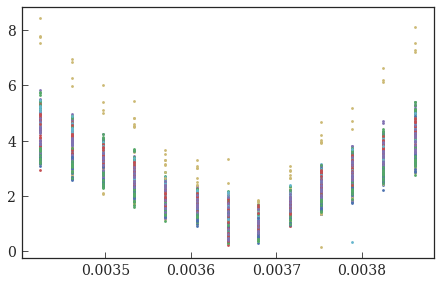

In [94]:
# sanity check 
for k in range(34):
    plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),osc_amplitude[:,k],'.')
    x1,x2,y1,y2 = plt.axis()
#     plt.axis((x1,x2,0,10))

Beta_x at PR.BPM00: 12.038661


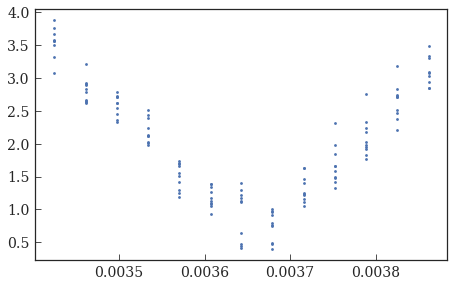

In [95]:
# manual inspection
bpm_n = 0
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),osc_amplitude[:,bpm_n],'.')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,10))
print 'Beta_x at '+BPM_name[bpm_n]+': '+str(BPM_betax[bpm_n])

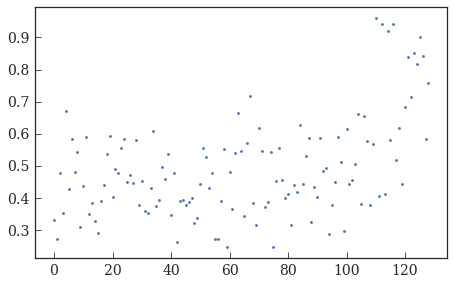

In [96]:
plt.plot(chi2[:,bpm_n],'.')

[ 3.43565017  1.32948228 -0.59076     2.1450949 ]
0.32829992179
0.328299921791


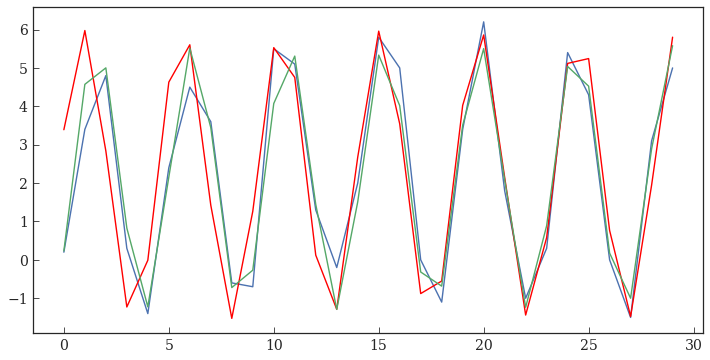

In [105]:
k = 0
m = 0 #bpm number

fig, ax  = plt.subplots(1,figsize=(12,6))
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,30,30)
ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m,0:30]).values[k]
ax.plot(ydata,'-')

p0 = ([1.5*np.std(ydata), 0.41*pi, 0.1*pi, np.mean(ydata)])
ax.plot(f_to_fit(xdata, *p0), 'r')

bounds=([-np.inf, 0.01*pi, -pi, -np.inf],[np.inf,pi/2.,pi,np.inf])

p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)

yfit = f_to_fit(xdata, *p)

ax.plot(yfit)

print(p)

print(np.sum((yfit - ydata)**2)/len(yfit))

print(chi2[k,m])

Text(0,0.5,u'Shot number')

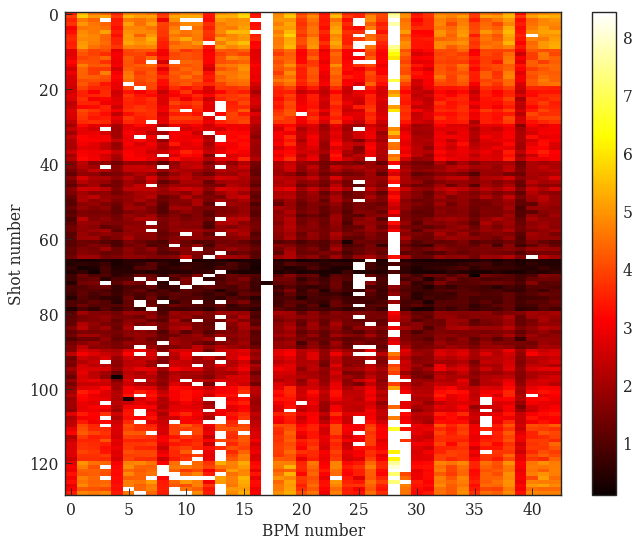

In [106]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(osc_amplitude[:,:],
           cmap='hot',
           aspect='auto'
          )
plt.colorbar()
plt.xlabel('BPM number')
plt.ylabel('Shot number')

## 2. RMS orbit deviation 1st-2nd turn and 1st turn-1ms orbit

### calculate the RMS orbit deviation
Use difference between the first and second turn to evaluate the orbit deviation from the reference orbit, where


$$\Delta x_\text{rms} =  \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn2} - x_\text{turn1})^2 }$$


excluding the BPM in the bump, that would dominate the estimator.

Same for the deviation from the orbit 

$$\Delta x_\text{rms, orbit} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn1} - x_\text{average_orbit_1ms})^2 }$$

In [107]:
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMx_turn2'].apply(lambda x: np.delete(x,17))
# bad BPM
mySeries1 = mySeries1.apply(lambda x: np.delete(x,36))
mySeries2 = mySeries2.apply(lambda x: np.delete(x,36))

# myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

myDataFrame['deltaX_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
# myDataFrame['OrbitX_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMy_turn2'].apply(lambda x: np.delete(x,17))
#bad BPM
mySeries1 = mySeries1.apply(lambda x: np.delete(x,36))
mySeries2 = mySeries2.apply(lambda x: np.delete(x,36))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

# myDataFrame['deltaY_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
# myDataFrame['OrbitY_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

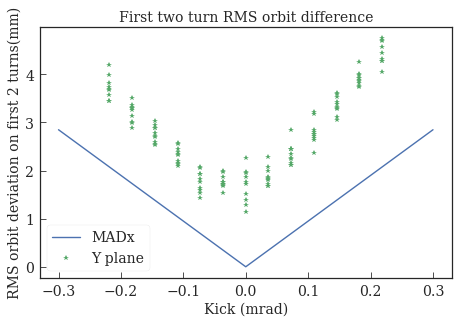

In [131]:
# DATA ONLY
# plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaX_2turns'].values,'*',label='X plane')

# plt.xlabel('Kick (mrad)')
# plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
# plt.title('First two turn RMS orbit difference')

# # plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaY_2turns'].values,'*',label='Y plane')



# plt.legend(frameon=True)
# x1,x2,y1,y2 = plt.axis()
# # plt.axis((x1,x2,0,8))
# # plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

# Comparison data + MADx 
kick_params = np.load('/eos/user/e/esenes/PS-injection-steering/MADx/6.21-6.185_kick_to_angle_params.npy')
xkick = np.array([ -0.3, 0., 0.3])
# off=1.5
plt.plot(xkick, kick_params[1] + np.abs(kick_params[0]*xkick),label='MADx')

plt.plot(1e3*(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal) - rk),myDataFrame['deltaX_2turns'].values,'*',label='Y plane')

plt.xlabel('Kick (mrad)')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference')

plt.legend(frameon=True)
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,8))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

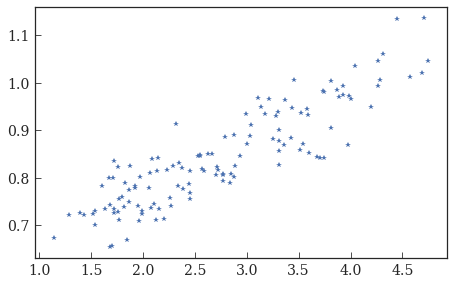

In [132]:
plt.plot(myDataFrame['deltaX_2turns'].values, myDataFrame['WS_geom_emittance_x'],'*',label='X plane')


In [133]:
xrms12_mean = np.empty(len(ks_idx),dtype=float)
xrms12_std = np.empty(len(ks_idx),dtype=float)


for k in range(len(ks_idx)):
    if k==len(ks_idx)-1:
        xrms12_mean[k] = np.mean(myDataFrame['deltaX_2turns'].iloc[ks_idx[k]:]) # the last tranche to close the array
        xrms12_std[k] = np.std(myDataFrame['deltaX_2turns'].iloc[ks_idx[k]:]) # the last tranche to close the array
    else:
        xrms12_mean[k] = np.mean(myDataFrame['deltaX_2turns'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        xrms12_std[k] = np.std(myDataFrame['deltaX_2turns'].iloc[ks_idx[k]:ks_idx[k+1]]) 



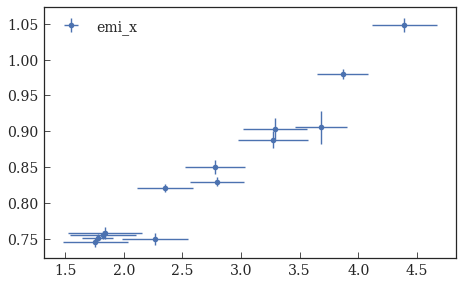

In [134]:
plt.errorbar(xrms12_mean, emix_mean, xerr=xrms12_std, yerr=emiy_std, fmt='o',label='emi_x')
plt.legend()

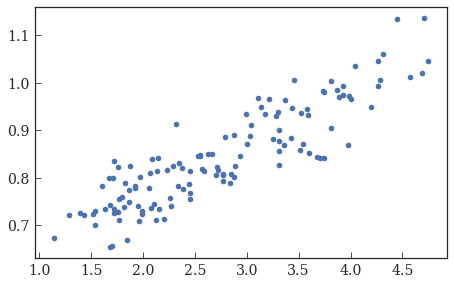

In [112]:
plt.plot(myDataFrame['deltaX_2turns'].values,myDataFrame['WS_geom_emittance_x'],'o')

# Methods comparison

## 1) Single BPM method

In [146]:
bpm_n1 = 0
osc1 = osc_amplitude[:,bpm_n1]
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))
bpm_n2 = 1
osc2 = osc_amplitude[:,bpm_n2]
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))

At PR.BPM00 betax=12.038661 alphax=0.009937008495
Expected value for the fit a=0.0415369593071
At PR.BPM03 betax=22.10670041 alphax=0.01858203422
Expected value for the fit a=0.0226253867254


Model function: a(x)^2 + c
Fit params: a=0.0195064559649 c= 7.50305997495e-07
 
At PR.BPM00 betax=12.038661 alphax=0.009937008495
Expected value for the fit a=0.0415369593071


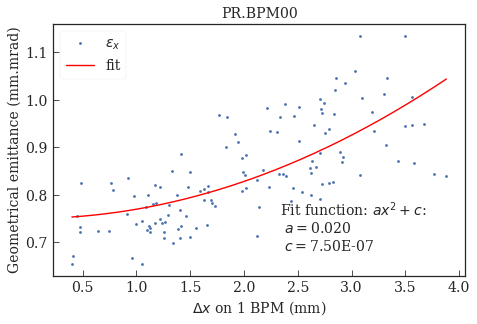

In [147]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x )**2 + c

xdata = 1e-3*osc1
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' c= '+ str(p[1])


plt.xlabel('$\Delta x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n1])

ax.text(0.55, 0.3, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))


plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,2.5))

fig.savefig('single_BPM185.eps', format='eps')

Model function: a(x)^2 + c
Fit params: a=0.00965222392862 c= 7.44837530347e-07
 
At PR.BPM03 betax=22.10670041 alphax=0.01858203422
Expected value for the fit a=0.0226253867254


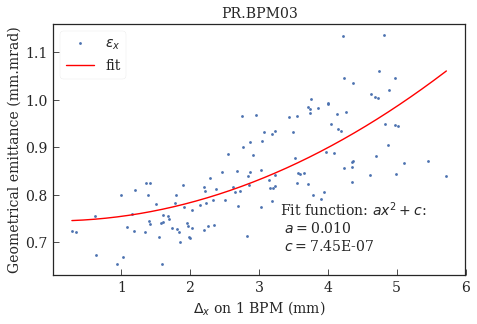

In [149]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x )**2 + c

xdata = 1e-3*osc2
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' c= '+ str(p[1])


plt.xlabel('$\Delta_x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n2])

ax.text(0.55, 0.3, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))

plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,1.9))

fig.savefig('single_BPM185.eps', format='eps')

## 2) All BPM - single turn method

In [139]:
exp_a_allBPM = np.mean((1 + (BPM_alphax**2))/(2*BPM_betax))

Model function: a(x)^2 + c
Fit params: 
 a= 0.0174712306312+/-0.000806788254562
 c= 6.9831436279e-07+/-7.9604912823e-09
 
Expected value for the fit a=0.0282644589046


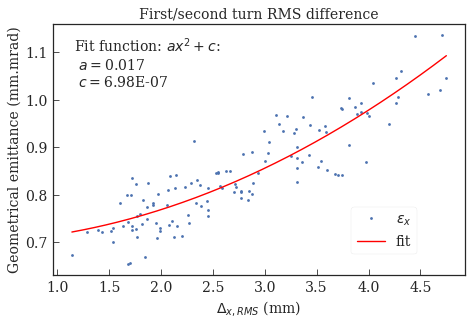

In [140]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x)**2 + c

xdata = 1e-3*myDataFrame['deltaX_2turns']
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)
err = np.sqrt(np.diag(cov))

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: \n a= ' + str(p[0]) + '+/-' + str(err[0]) + '\n c= '+ str(p[1]) + '+/-' + str(err[1])


plt.xlabel('$\Delta_{x,RMS}$ (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title('First/second turn RMS difference')

ax.text(0.05, 0.95, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True, bbox_to_anchor=(0.9,0.3))
print ' '
print 'Expected value for the fit a='+str(exp_a_allBPM)



x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,1.9))

fig.savefig('all_BPM185.eps', format='eps')

# Laslett tune shift calculation

In [81]:
myDataFrame['peakLineDensity'] = 0.6

In [82]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [83]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

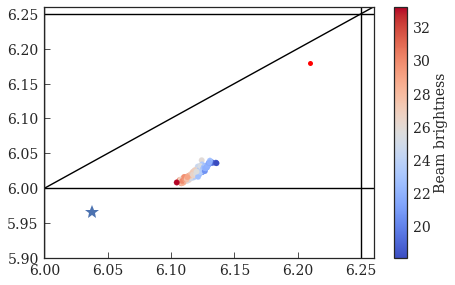

In [98]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.21
Qy = 6.18
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([6.0, 6.26])
plt.ylim([5.9, 6.26])
# tune shifts
p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

# PSB point
[deltaQxPSB, deltaQyPSB] = laslett_sc_PS(0.6, 0.5e-3,
              1e-6*0.943, 1e-6*0.775,
              1400, twiss_file_name)
plt.plot(Qx+deltaQxPSB,Qy+deltaQyPSB,'*',markersize=15)


plt.show()

fig.savefig('BCMS_under_coupling_footprint.eps', format='eps')

In [95]:
myDataFrame['WS_emittance_y'].min()

0.80106210163967961